# Time Serie Forecast

In this notebook we will use **SageMaker DeepAR** to perform time series prediction. The data we will be using is provided by [Kaggle](https://www.kaggle.com/uciml/electric-power-consumption-data-set); a global household eletric power consumption data set collected over years from 2006 to 2010. A large dataset like this allows us to make time series prediction over long periods of time, like weeks or months. 

## Data Exploration

Let's get started by exploring the data and see what's contained within the data set.

In [1]:
! wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/March/5c88a3f1_household-electric-power-consumption/household-electric-power-consumption.zip

--2020-04-22 01:54:44--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/March/5c88a3f1_household-electric-power-consumption/household-electric-power-consumption.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.142.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.142.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20805339 (20M) [application/zip]
Saving to: ‘household-electric-power-consumption.zip’

household-electric- 100%[===================>]  19.84M  8.19MB/s    in 2.4s    

2020-04-22 01:54:47 (8.19 MB/s) - ‘household-electric-power-consumption.zip’ saved [20805339/20805339]



In [2]:
! unzip household-electric-power-consumption

Archive:  household-electric-power-consumption.zip
  inflating: household_power_consumption.txt  


In [3]:
with open('household_power_consumption.txt') as file:
    for line in range(10):
        print(next(file))

Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3

16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000

16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000

16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000

16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000

16/12/2006;17:28:00;3.666;0.528;235.680;15.800;0.000;1.000;17.000

16/12/2006;17:29:00;3.520;0.522;235.020;15.000;0.000;2.000;17.000

16/12/2006;17:30:00;3.702;0.520;235.090;15.800;0.000;1.000;17.000

16/12/2006;17:31:00;3.700;0.520;235.220;15.800;0.000;1.000;17.000

16/12/2006;17:32:00;3.668;0.510;233.990;15.800;0.000;1.000;17.000



We've downloaded a text file which has a similar format to that of CSV except it is separated by `;`.

## Data Preprocessing

The text file has the following attributes,

- Each data point has date and time of recording
- Each feature is separated by ;
- Some values are either NaN or ?, we'll treat them as `NaN` in DataFrame

For `NaN` values, instead of dropping them, we want to fill them with the mean value of that column. This is to ensure our time series is nice and smooth. It's not a terrible assumption to make that if a record is missing, it's likely that the record has a mean value of energy consumption, given that we don't have that many missing values.

### Load Text Data into Data Frame

In [4]:
import pandas as pd


df = pd.read_csv('household_power_consumption.txt', sep=';',
                                                    parse_dates={'Date-Time': ['Date', 'Time']},
                                                    infer_datetime_format=True,
                                                    low_memory=False,
                                                    na_values=['nan', '?'],
                                                    index_col='Date-Time')

In [5]:
print('Number of missing values per column')
df.isnull().sum()

Number of missing values per column


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
print('Numer of values per column')
df.count()

Numer of values per column


Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

### Replace NaN with Mean

In [7]:
num_cols = len(list(df.columns.values))
for col in range(num_cols):        
    df.iloc[:,col]=df.iloc[:,col].fillna(df.iloc[:,col].mean())
    
print('Number of missing values per column')
df.isnull().sum()

Number of missing values per column


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date-Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Display Global Active Power

For this demonstration, we will predict global active power. We can ignore the other columns.

In [9]:
active_power_df = df['Global_active_power'].copy()

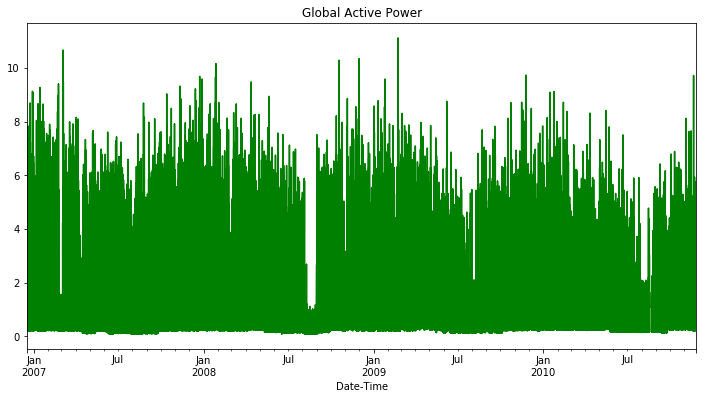

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(12,6))
active_power_df.plot(title='Global Active Power', color='green')
plt.show()

The data are recorded each minute, we want to zoom into one day worth of data and see what it looks like.

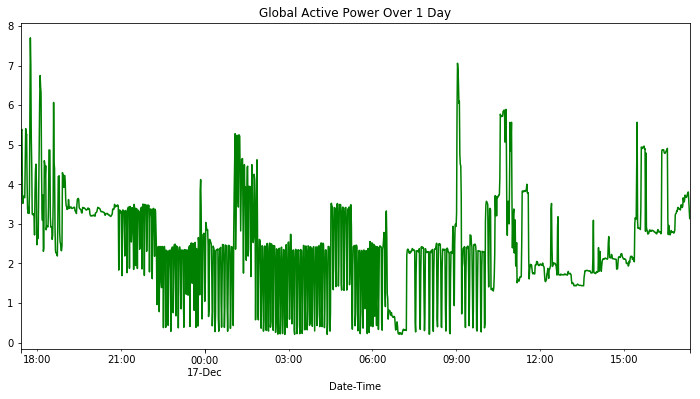

In [11]:
# There are 1440 minutes in a day
plt.figure(figsize=(12,6))
active_power_df[0:1440].plot(title='Global Active Power Over 1 Day', color='green')
plt.show()

### Hourly vs Daily

With this amount of data, there are many interesting approaches to this problem. 

1. Create many short time series, predict the energy consumption over hours or days.
2. Create fewer but longer time series, predict the energy consumption over seasons.

For the purpose of demonstrating `pandas` resampling, we will go with the latter. We need to convert the minute data points into hour or day data points. Pandas' [time series tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) allow us to easily resample time series data by frequency, e.g. hourly `H` or daily `D`

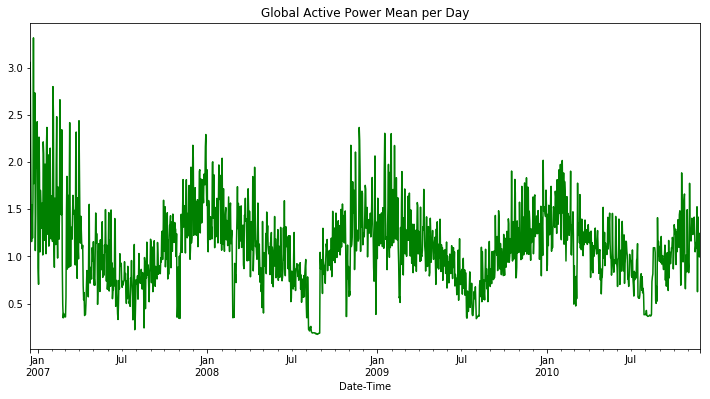

In [12]:
# Set frequency to be daily
freq = 'D'
mean_active_power_df = active_power_df.resample(freq).mean()

plt.figure(figsize=(12,6))
mean_active_power_df.plot(title='Global Active Power Mean per Day', color='green')
plt.show()

### Create Time Series Training Data

The objective is to train a model on a 3 years of data and use the 4th year as the test set to predict what will be the power usage in first few months of 2010. There wil be 3 year-long time series from the years 2007, 2008, and 2009.

In [13]:
def create_time_series_list_by_years(df, years, freq='D', start_idx=0):
    """Creates time series for each supplied year in the years list.
    """
    leap = '2008' # We should account for all leap years but for the purpose of this demo, 2008 is enough
    time_series_list = []
    for i in range(len(years)):
        if years[i] == leap:
            end_idx = start_idx + 366
        else:
            end_idx = start_idx + 365
        
        index = pd.date_range(start=years[i] + '-01-01', end=years[i] + '-12-31', freq=freq)
        time_series_list.append(pd.Series(data=df[start_idx:end_idx], index=index))
        start_idx = end_idx
    
    return time_series_list

Now we can plot the time series and see that there are 3 series, each has length either 365 or 366, depending on whether it is a leap year or not. 

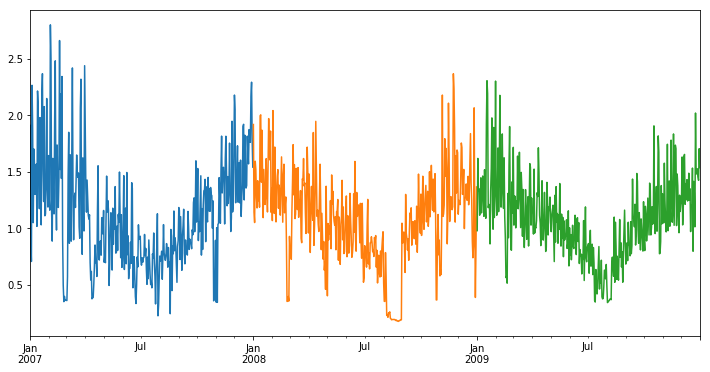

In [14]:
time_series_list = create_time_series_list_by_years(mean_active_power_df, ['2007', '2008', '2009'], start_idx=16)

plt.figure(figsize=(12,6))
for ts in time_series_list:
    ts.plot()

plt.show()

### Training Feature/Label Split in Time

This is supervised learning, we need to provide our training set with some labels or targets. One simple way to think about it is to split the year-long time series into two chunks. The first chunk is the training, while the second chunk is the label. We are training a model to accept an input time series and return a prediction time series. Let's call the length of the prediction time series `prediction_length`.

For example, I have 365 days of data. I want my prediction length to be a month or 30 days. The input time series would have 335 data points while the label or target time series would have 30 data points. This split must occur in time though. We cannot randomly choose 30 days out of 365 days.

In [15]:
prediction_length = 30 # Days

training_list = []
for ts in time_series_list:
    training_list.append(ts[:-prediction_length])
    
    
for ts in training_list:
    print('Training set has shape {} after truncating {} days'.format(ts.shape, prediction_length))

Training set has shape (335,) after truncating 30 days
Training set has shape (336,) after truncating 30 days
Training set has shape (335,) after truncating 30 days


Now let's visualize the split.

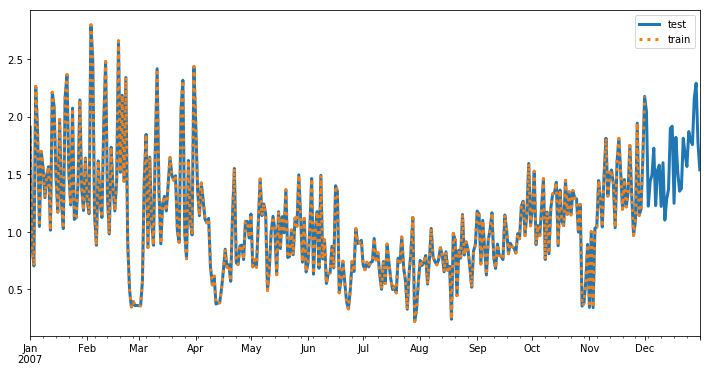

In [16]:
plt.figure(figsize=(12,6))
time_series_list[0].plot(label='test', lw=3)
training_list[0].plot(label='train', ls=':', lw=3)
plt.legend()
plt.show()

## DeepAR

### Save as JSON

Before we run DeepAR on SageMaker, we need to do one final data preparation, i.e. converting the data frames into JSON format that is accepted by DeepAR.

DeepAR expects to see input training data in the following JSON fields.

- `start`: a string that defines the starting date of the time series YYYY-MM-DD HH:MM:SS
- `target`: a list of numerical values that represent the time series
- `cat`: optional, a numerical array of categorical features that can be used to encode the groups that the record
  belongs to. This is useful for finding models per class of item.
  
For example,

```json
{
  "start": "2007-01-01 00:00:00"
  "target": [1.1, 2.2, 3.3],
  "cat": [1]
}
```

In [17]:
import json
import os


def write_json_dataset(time_series_list, data_dir, filename):
    if not os.path.exists(data_dir):
       os.makedirs(data_dir) 
    
    with open(os.path.join(data_dir, filename), 'wb') as f:
        for ts in time_series_list:
            json_line = json.dumps({
                'start': str(ts.index[0]),
                'target': list(ts)
            }) + '\n'
            f.write(json_line.encode('utf-8'))

In [18]:
local_data_dir = 'energy_json_data'

write_json_dataset(training_list, local_data_dir, 'train.json')
write_json_dataset(time_series_list, local_data_dir, 'test.json')

### Upload to S3

Just as any other built-in models, SageMaker expects the JSON data to be in a S3 bucket during training and inference job.

In [19]:
import boto3
import sagemaker


session = sagemaker.Session(default_bucket='machine-learning-case-studies')
role = sagemaker.get_execution_role()

s3_bucket = session.default_bucket()
s3_prefix = 'deepar-energy-consumption'

print('Instantiated session with default bucket {}'.format(s3_bucket))

train_path = session.upload_data(os.path.join(local_data_dir, 'train.json'), bucket=s3_bucket, key_prefix=s3_prefix)
test_path = session.upload_data(os.path.join(local_data_dir, 'test.json'), bucket=s3_bucket, key_prefix=s3_prefix)

print('Training data are stored in {}'.format(train_path))
print('Test data are stored in {}'.format(test_path))

Instantiated session with default bucket machine-learning-case-studies
Training data are stored in s3://machine-learning-case-studies/deepar-energy-consumption/train.json
Test data are stored in s3://machine-learning-case-studies/deepar-energy-consumption/test.json


### DeepAR Estimator

Instantiate an estimator

In [20]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator


s3_output_path = 's3://{}/{}'.format(s3_bucket, s3_prefix)

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
estimator = Estimator(sagemaker_session=session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path)

There are couple hyperparameters we need to set. 

- `epochs`: The maximum number of times to pass over the data when training.
- `time_freq`: The granularity of time series in the dataset, e.g. `D` for daily.
- `prediction_length`: The number of time steps that the model is trained to predict.
- `context_length`: The number of data points that the model gets to see before making a prediction.

More information can be found on [Deep AR Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html)

In [21]:
hyperparameters = {
    'epochs': '50',
    'time_freq': 'D', # Day
    'prediction_length': '30',
    'context_length': '30',
    'num_layers': '2',
    'num_cells': '50',
    'mini_batch_size': '128',
    'learning_rate': '0.001',
    'early_stopping_patience': '10'
}

estimator.set_hyperparameters(**hyperparameters)

When we provide inputs toe the `fit` function, if we provide a test dataset, DeepAR will calculate the accuracy metrics for the trained model. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing it to the actual value of the time series. The computed error metrics will be included as part of the log output.

In [22]:
estimator.fit(inputs={
    'train': train_path,
    'test': test_path
})

2020-04-22 01:55:18 Starting - Starting the training job...
2020-04-22 01:55:20 Starting - Launching requested ML instances...............
2020-04-22 01:57:54 Starting - Preparing the instances for training......
2020-04-22 01:58:56 Downloading - Downloading input data...
2020-04-22 01:59:35 Training - Training image download completed. Training in progress.Arguments: train
[04/22/2020 01:59:38 INFO 139879024285504] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_pa

[04/22/2020 01:59:44 INFO 139879024285504] Epoch[2] Batch[0] avg_epoch_loss=0.424001
[04/22/2020 01:59:44 INFO 139879024285504] #quality_metric: host=algo-1, epoch=2, batch=0 train loss <loss>=0.424000680447
[04/22/2020 01:59:45 INFO 139879024285504] Epoch[2] Batch[5] avg_epoch_loss=0.397201
[04/22/2020 01:59:45 INFO 139879024285504] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=0.397201354305
[04/22/2020 01:59:45 INFO 139879024285504] Epoch[2] Batch [5]#011Speed: 738.12 samples/sec#011loss=0.397201
[04/22/2020 01:59:46 INFO 139879024285504] Epoch[2] Batch[10] avg_epoch_loss=0.399436
[04/22/2020 01:59:46 INFO 139879024285504] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=0.402117389441
[04/22/2020 01:59:46 INFO 139879024285504] Epoch[2] Batch [10]#011Speed: 749.73 samples/sec#011loss=0.402117
[04/22/2020 01:59:46 INFO 139879024285504] processed a total of 1332 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2260.17689704895, "sum

[04/22/2020 01:59:54 INFO 139879024285504] Epoch[6] Batch[5] avg_epoch_loss=0.176929
[04/22/2020 01:59:54 INFO 139879024285504] #quality_metric: host=algo-1, epoch=6, batch=5 train loss <loss>=0.176929290096
[04/22/2020 01:59:54 INFO 139879024285504] Epoch[6] Batch [5]#011Speed: 742.76 samples/sec#011loss=0.176929
[04/22/2020 01:59:55 INFO 139879024285504] Epoch[6] Batch[10] avg_epoch_loss=0.149889
[04/22/2020 01:59:55 INFO 139879024285504] #quality_metric: host=algo-1, epoch=6, batch=10 train loss <loss>=0.117440098524
[04/22/2020 01:59:55 INFO 139879024285504] Epoch[6] Batch [10]#011Speed: 749.91 samples/sec#011loss=0.117440
[04/22/2020 01:59:55 INFO 139879024285504] processed a total of 1321 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2264.5602226257324, "sum": 2264.5602226257324, "min": 2264.5602226257324}}, "EndTime": 1587520795.467939, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587520793.203313}

[04/2

[04/22/2020 02:00:04 INFO 139879024285504] processed a total of 1227 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2131.3250064849854, "sum": 2131.3250064849854, "min": 2131.3250064849854}}, "EndTime": 1587520804.497748, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587520802.366362}

[04/22/2020 02:00:04 INFO 139879024285504] #throughput_metric: host=algo-1, train throughput=575.668462924 records/second
[04/22/2020 02:00:04 INFO 139879024285504] #progress_metric: host=algo-1, completed 22 % of epochs
[04/22/2020 02:00:04 INFO 139879024285504] #quality_metric: host=algo-1, epoch=10, train loss <loss>=0.118240898103
[04/22/2020 02:00:04 INFO 139879024285504] best epoch loss so far
[04/22/2020 02:00:04 INFO 139879024285504] Saved checkpoint to "/opt/ml/model/state_b450b572-c0b9-470b-94aa-a2fa9434293a-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 29.677867889404297, "sum": 29.6778678

[04/22/2020 02:00:19 INFO 139879024285504] Epoch[17] Batch[5] avg_epoch_loss=0.017824
[04/22/2020 02:00:19 INFO 139879024285504] #quality_metric: host=algo-1, epoch=17, batch=5 train loss <loss>=0.0178237376385
[04/22/2020 02:00:19 INFO 139879024285504] Epoch[17] Batch [5]#011Speed: 739.78 samples/sec#011loss=0.017824
[04/22/2020 02:00:20 INFO 139879024285504] processed a total of 1224 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2083.9080810546875, "sum": 2083.9080810546875, "min": 2083.9080810546875}}, "EndTime": 1587520820.470224, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587520818.385699}

[04/22/2020 02:00:20 INFO 139879024285504] #throughput_metric: host=algo-1, train throughput=587.328662919 records/second
[04/22/2020 02:00:20 INFO 139879024285504] #progress_metric: host=algo-1, completed 36 % of epochs
[04/22/2020 02:00:20 INFO 139879024285504] #quality_metric: host=algo-1, epoch=17, train loss <loss

[04/22/2020 02:00:34 INFO 139879024285504] Epoch[24] Batch[0] avg_epoch_loss=0.001755
[04/22/2020 02:00:34 INFO 139879024285504] #quality_metric: host=algo-1, epoch=24, batch=0 train loss <loss>=0.00175462896004
[04/22/2020 02:00:35 INFO 139879024285504] Epoch[24] Batch[5] avg_epoch_loss=-0.017756
[04/22/2020 02:00:35 INFO 139879024285504] #quality_metric: host=algo-1, epoch=24, batch=5 train loss <loss>=-0.0177561329522
[04/22/2020 02:00:35 INFO 139879024285504] Epoch[24] Batch [5]#011Speed: 740.93 samples/sec#011loss=-0.017756
[04/22/2020 02:00:36 INFO 139879024285504] Epoch[24] Batch[10] avg_epoch_loss=-0.034849
[04/22/2020 02:00:36 INFO 139879024285504] #quality_metric: host=algo-1, epoch=24, batch=10 train loss <loss>=-0.0553597286344
[04/22/2020 02:00:36 INFO 139879024285504] Epoch[24] Batch [10]#011Speed: 740.34 samples/sec#011loss=-0.055360
[04/22/2020 02:00:36 INFO 139879024285504] processed a total of 1337 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2271

[04/22/2020 02:00:49 INFO 139879024285504] Epoch[30] Batch[10] avg_epoch_loss=-0.080415
[04/22/2020 02:00:49 INFO 139879024285504] #quality_metric: host=algo-1, epoch=30, batch=10 train loss <loss>=-0.107514408231
[04/22/2020 02:00:49 INFO 139879024285504] Epoch[30] Batch [10]#011Speed: 740.81 samples/sec#011loss=-0.107514
[04/22/2020 02:00:49 INFO 139879024285504] processed a total of 1314 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2282.1309566497803, "sum": 2282.1309566497803, "min": 2282.1309566497803}}, "EndTime": 1587520849.680604, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587520847.398408}

[04/22/2020 02:00:49 INFO 139879024285504] #throughput_metric: host=algo-1, train throughput=575.746312551 records/second
[04/22/2020 02:00:49 INFO 139879024285504] #progress_metric: host=algo-1, completed 62 % of epochs
[04/22/2020 02:00:49 INFO 139879024285504] #quality_metric: host=algo-1, epoch=30, train loss 

[04/22/2020 02:00:59 INFO 139879024285504] Epoch[35] Batch[0] avg_epoch_loss=-0.120112
[04/22/2020 02:00:59 INFO 139879024285504] #quality_metric: host=algo-1, epoch=35, batch=0 train loss <loss>=-0.120111569762
[04/22/2020 02:01:00 INFO 139879024285504] Epoch[35] Batch[5] avg_epoch_loss=-0.090690
[04/22/2020 02:01:00 INFO 139879024285504] #quality_metric: host=algo-1, epoch=35, batch=5 train loss <loss>=-0.0906896299372
[04/22/2020 02:01:00 INFO 139879024285504] Epoch[35] Batch [5]#011Speed: 734.77 samples/sec#011loss=-0.090690
[04/22/2020 02:01:01 INFO 139879024285504] Epoch[35] Batch[10] avg_epoch_loss=-0.105231
[04/22/2020 02:01:01 INFO 139879024285504] #quality_metric: host=algo-1, epoch=35, batch=10 train loss <loss>=-0.122679784894
[04/22/2020 02:01:01 INFO 139879024285504] Epoch[35] Batch [10]#011Speed: 744.06 samples/sec#011loss=-0.122680
[04/22/2020 02:01:01 INFO 139879024285504] processed a total of 1335 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2325.

[04/22/2020 02:01:19 INFO 139879024285504] Epoch[43] Batch[10] avg_epoch_loss=-0.131925
[04/22/2020 02:01:19 INFO 139879024285504] #quality_metric: host=algo-1, epoch=43, batch=10 train loss <loss>=-0.151498360932
[04/22/2020 02:01:19 INFO 139879024285504] Epoch[43] Batch [10]#011Speed: 738.84 samples/sec#011loss=-0.151498
[04/22/2020 02:01:19 INFO 139879024285504] processed a total of 1302 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2298.6350059509277, "sum": 2298.6350059509277, "min": 2298.6350059509277}}, "EndTime": 1587520879.271792, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587520876.972645}

[04/22/2020 02:01:19 INFO 139879024285504] #throughput_metric: host=algo-1, train throughput=566.392566286 records/second
[04/22/2020 02:01:19 INFO 139879024285504] #progress_metric: host=algo-1, completed 88 % of epochs
[04/22/2020 02:01:19 INFO 139879024285504] #quality_metric: host=algo-1, epoch=43, train loss 


2020-04-22 02:01:44 Uploading - Uploading generated training model
2020-04-22 02:01:44 Completed - Training job completed
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 4096.864938735962, "sum": 4096.864938735962, "min": 4096.864938735962}}, "EndTime": 1587520896.959551, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1587520892.862805}

[04/22/2020 02:01:36 INFO 139879024285504] #test_score (algo-1, RMSE): 0.331712309797
[04/22/2020 02:01:36 INFO 139879024285504] #test_score (algo-1, mean_absolute_QuantileLoss): 17.675624722242354
[04/22/2020 02:01:36 INFO 139879024285504] #test_score (algo-1, mean_wQuantileLoss): 0.13839414794456764
[04/22/2020 02:01:36 INFO 139879024285504] #test_score (algo-1, wQuantileLoss[0.1]): 0.07906320628913725
[04/22/2020 02:01:36 INFO 139879024285504] #test_score (algo-1, wQuantileLoss[0.2]): 0.12381355204049545
[04/22/2020 02:01:36 INFO 139879024285504] #test_score (algo-1, wQuantileLoss[0.

Deploy it and make it ready for inference.

In [23]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.t2.medium',
                             content_type='application/json')

-------------!

## Model Evaluation

### Generate Predictions

DeepAR predictor expects JSON for inputs, the input should have the following keys.

- `instances`: A list of JSON formatted time series
- `configuration` optional: A dictionary of configuration information for the response
  - `num_samples`
  - `output_types`
  - `quantiles`
  
More information on [DeepAR Inference Formats](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html)

In [32]:
def to_json_predictor_input(ts_list, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    instances = []
    for i in range(len(ts_list)):
        instances.append({
            'start': str(ts_list[i].index[0]),
            'target': list(ts_list[i])
        })
    
    configuration = {
        'output_types': ['quantiles'],
        'num_samples': num_samples,
        'quantiles': quantiles
    }
    
    json_request = json.dumps({
        'instances': instances,
        'configuration': configuration
    }).encode('utf-8')
    
    return json_request


prediction = predictor.predict(to_json_predictor_input(training_list))

The prediction JSON would look something like the following. We need to decode string into JSON object and then load the data into a DataFrame.

```json
{
   "predictions":[
      {
         "quantiles":{
            "0.1":[numbers...],
            "0.9":[numbers...],
            "0.5":[numbers...]
         }
      },
      {
         "quantiles":{
            "0.1":[numbers...],
            "0.9":[numbers...],
            "0.5":[numbers...]
         }
      },
      {
         "quantiles":{
            "0.1":[numbers...],
            "0.9":[numbers...],
            "0.5":[numbers...]
         }
      }
   ]
}
```

In [35]:
def decode_prediction(prediction_json, encoding='utf-8'):
    json_data = json.loads(prediction_json.decode(encoding))
    pd_list = []
    for i in range(len(json_data['predictions'])):
        pd_list.append(pd.DataFrame(data=json_data['predictions'][i]['quantiles']))

    return pd_list


results = decode_prediction(prediction)

print(results[0])

         0.1       0.9       0.5
0   1.088849  1.828646  1.502092
1   1.022624  1.551457  1.282422
2   1.305507  1.900849  1.538800
3   1.033439  1.458136  1.265341
4   0.873974  1.416162  1.145868
5   1.183307  1.786330  1.489765
6   1.358921  1.893588  1.658125
7   1.023880  1.776468  1.353857
8   0.816724  1.451042  1.169706
9   0.989871  1.643647  1.341426
10  0.954561  1.471301  1.141534
11  0.882861  1.549521  1.137189
12  1.066164  1.888121  1.350396
13  1.008170  1.875113  1.396235
14  1.088461  2.301020  1.586839
15  1.058260  1.541146  1.302700
16  1.191627  1.804835  1.495359
17  1.081382  1.848557  1.330365
18  0.916280  1.782442  1.443959
19  1.096332  1.851947  1.503171
20  1.189601  2.429537  1.660283
21  0.864012  2.223838  1.407799
22  0.906846  1.819857  1.251403
23  1.061913  1.900574  1.439155
24  0.908473  1.759717  1.377292
25  0.656686  1.697152  1.085249
26  0.702556  2.054829  1.307726
27  0.484136  1.871403  1.430208
28  0.824297  1.891673  1.406972
29  0.6719

### Visualize the Results

- Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
- Quantile 0.5 represents the median of all sample predictions.

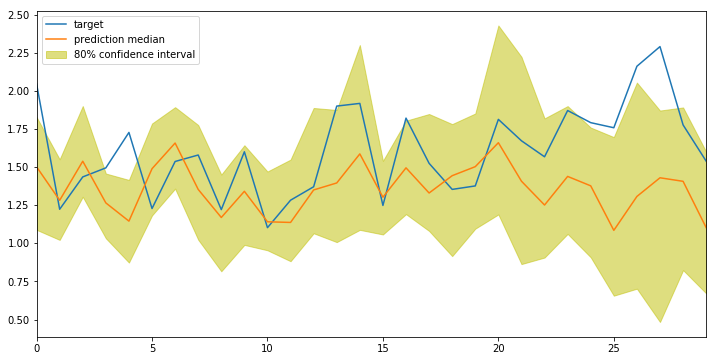

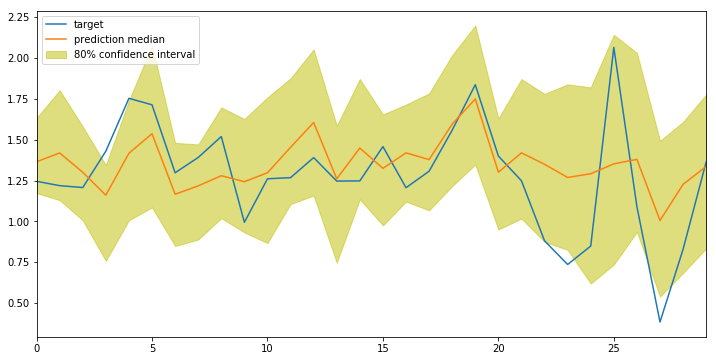

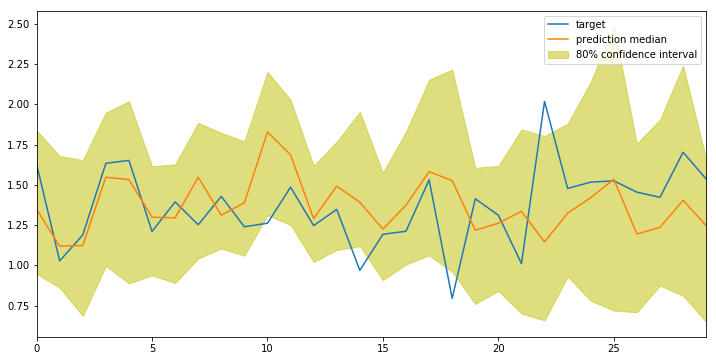

In [41]:
def display_quantiles(prediction_list, target=None, prediction_length=30):
    for i in range(len(prediction_list)):
        plt.figure(figsize=(12, 6))
        if target is not None:
            target_ts = target[i][-prediction_length:]
            plt.plot(range(len(target_ts)), target_ts, label='target')
        
        p10 = prediction_list[i]['0.1']
        p90 = prediction_list[i]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        prediction_list[i]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()


display_quantiles(results, target=time_series_list)

### Predicting the Future

Now we have verified that the predictor works and it can capture patterns fairly well, we can use it to predict the future, i.e. the months in 2010. We will leave `target` empty and reserve the 2010 data for testing. In fact we could provide the historical data as target and let the model to predict the future.

In [49]:
start_date = '2010-01-01' # We want to predict first 30 days in 2010
timestamp = '00:00:00'
request_data = {
    'instances': [
        { 'start': '{} {}'.format(start_date, timestamp), 'target': [] }
    ],
    'configuration': {
        'num_samples': 50,
        'output_types': ['quantiles'],
        'quantiles': ['0.1', '0.5', '0.9']
    }
}

predictions_2010 = decode_prediction(predictor.predict(json.dumps(request_data).encode('utf-8')))

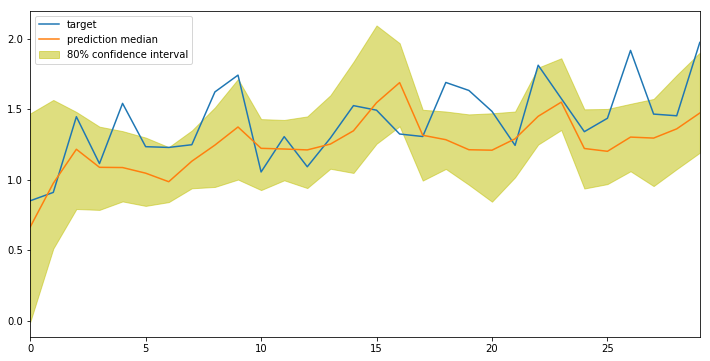

In [50]:
pd_series_2010 = pd.Series(data=mean_active_power_df.values[1112:],
                           index=pd.date_range(start=start_date,
                                               periods=len(mean_active_power_df.values[1112:]),
                                               freq=freq)
                          )


display_quantiles(predictions_2010, [pd_series_2010[0:prediction_length]])

The result came out to be not too bad! Now it's time to clean up.

In [52]:
predictor.delete_endpoint()